In [ ]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

TRAINING_DIR = 'drive/My Drive/dataset/prepared/Training/'
training_datagen = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      zoom_range = 0.2,
                                      width_shift_range = 0.10,
                                      height_shift_range = 0.10,
                                      rotation_range = 30)

VALIDATION_DIR = 'drive/My Drive/dataset/prepared/Validation/'
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                      target_size=(224,224),
                                                      class_mode = 'categorical',
                                                      batch_size = 32)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                             target_size=(224,224),
                                                             class_mode = 'categorical',
                                                             batch_size=32)

label_map = train_generator.class_indices

Found 320 images belonging to 8 classes.
Found 44 images belonging to 8 classes.


In [ ]:
mc = ModelCheckpoint('drive/My Drive/models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

basemodel = VGG16(input_shape = (224,224,3), weights = 'imagenet', include_top = False)

for layer in basemodel.layers:
    layer.trainable = False

    
last_layer = basemodel.get_layer('block5_pool')
new_model = layers.Flatten()(last_layer.output)

new_model = layers.Dense(1024, activation='relu')(new_model)
new_model = layers.BatchNormalization()(new_model)
new_model = layers.Dropout(0.2)(new_model)

new_model = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l1(0.01),
                              activity_regularizer=tf.keras.regularizers.l2(0.01))(new_model)
new_model = layers.BatchNormalization()(new_model)
new_model = layers.Dropout(0.2)(new_model)

new_model = layers.Dense(8, activation='softmax')(new_model)

model = Model(basemodel.input, new_model)

model.compile(loss = 'categorical_crossentropy', optimizer = Adam(lr= 0.0001), metrics = ['accuracy'])

history = model.fit(train_generator, 
                    epochs= 250, 
                    steps_per_epoch=10, 
                    validation_data = validation_generator, 
                    verbose = 1,
                    callbacks=[mc])

Epoch 1/250
10/10 [==============================] - ETA: 0s - loss: 167.6400 - accuracy: 0.2281
Epoch 00001: val_accuracy improved from -inf to 0.22727, saving model to drive/My Drive/models/best_model.h5
10/10 [==============================] - 10s 1s/step - loss: 167.6400 - accuracy: 0.2281 - val_loss: 164.0247 - val_accuracy: 0.2273
Epoch 2/250
10/10 [==============================] - ETA: 0s - loss: 162.6946 - accuracy: 0.5000
Epoch 00002: val_accuracy did not improve from 0.22727
10/10 [==============================] - 7s 701ms/step - loss: 162.6946 - accuracy: 0.5000 - val_loss: 160.8589 - val_accuracy: 0.2273
Epoch 3/250
10/10 [==============================] - ETA: 0s - loss: 158.4641 - accuracy: 0.6125
Epoch 00003: val_accuracy did not improve from 0.22727
10/10 [==============================] - 8s 780ms/step - loss: 158.4641 - accuracy: 0.6125 - val_loss: 157.5168 - val_accuracy: 0.2273
Epoch 4/250
10/10 [==============================] - ETA: 0s - loss: 154.3119 - accurac

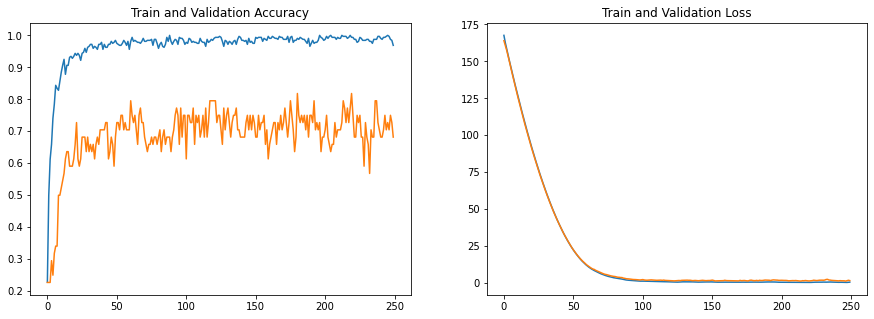

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(train_acc))

plt.figure(figsize = (15, 5))

ax = plt.subplot(1,2,1)
plt.title('Train and Validation Accuracy')
sns.lineplot(epochs, train_acc)
sns.lineplot(epochs, val_acc)

ax = plt.subplot(1,2,2)
plt.title('Train and Validation Loss')
sns.lineplot(epochs, train_loss)
sns.lineplot(epochs, val_loss)

In [14]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
from tensorflow.keras.models import load_model

model = load_model('/content/drive/My Drive/models/best_model.h5')
test_df = pd.read_csv('drive/My Drive/dataset/raw/test.csv')
test_df['target'] = -1
test_path = os.path.join('drive', 'My Drive', 'dataset', 'raw', 'test')

for idx in range(test_df.shape[0]):
    test_file = os.path.join(test_path , test_df['Image'].iloc[idx])
    img = image.load_img(test_file, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    y_prob = model.predict(x) 
    y_class = y_prob.argmax(axis=-1)
    for key,val in label_map.items():
        if(y_class[0] == val):
            test_df['target'].iloc[idx] = key

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [15]:
test_save= test_df.set_index('Image')
test_save.to_csv('drive/My Drive/submit.csv')